In [1]:
library(tidyverse)
library(repr)
library(broom)
library(leaps)
library(moderndive)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## 1. Title

## 2. Introduction:


Sleep plays a crucial role in maintaining physical and mental health. Disruptions in sleep quality or duration have been consistently associated with increased stress levels, cardiovascular risk, and metabolic issues such as obesity. As lifestyles become more demanding and sedentary, understanding how daily habits impact sleep health is both timely and essential. For this project, we use the Sleep Health and Lifestyle Dataset which contains 374 observations and 13 variables, covering sleep quality, daily activity, stress, and cardiovascular health. It includes numerical and categorical data, such as sleep duration (hours), self-reported sleep quality (1-10 scale), physical activity level (minutes/day), stress level (1-10 scale), BMI category, and presence of sleep disorders (None, Insomnia, Sleep Apnea). This dataset helps analyze the relationship between lifestyle choices and sleep health. 

Our inference-based research question is as follows:
We wish to examine the association between a person's sleep (duration/quality) and predictors such as their physical health (namely BMI, physical activity level, etc.) and meantal health (such as sleep disorder, stress level, etc.)
Our question is primarily focused on inference, as our goal is to examine association intead of predicting values. By examining the model’s coefficients, we can interpret how each factor contributes to changes in sleep duration, providing insights into potential lifestyle adjustments for better sleep health.

There’s already quite a bit of research highlighting how lifestyle choices are connected to sleep health. For example, Grandner (2017) points out that behaviors like physical activity and diet play an important role in sleep quality. Medic et al. (2017) explain how poor sleep can affect both mental and physical health, especially through stress and cardiovascular issues. Similarly, Khan and Aouad (2017) show links between sleep loss and cardiovascular risk factors like high BMI and blood pressure. These studies help back up the relevance of the variables we’re exploring and show why it makes sense to look for associations between them and sleep disorders in this project.

## 3. Methods and Results

#### a) Data 

In [2]:
file_url <- "https://drive.google.com/uc?export=download&id=1ZjZvLl5dUzHEF8ouimlTg8t0MorhjzVA"
sleep_data <- read.csv(file_url)
head(sleep_data)

,Person.ID,Gender,Age,Occupation,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,BMI.Category,Blood.Pressure,Heart.Rate,Daily.Steps,Sleep.Disorder
,<int>,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


Dataset used: Laksika Tharmalingam. 2024. Sleep Health and Lifestyle Dataset. Retrieved from https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data

A detailed description of all the variables in the dataset is as follows:-

| Variable | Type of Variable | Description |
| -------- | --------------- | ----------- |
| Person ID | Numeric | Unique identifier for each individual |
| Gender | Categorical | Gender of the individual (Male/Female) |
| Age | Numeric | Age of the individual in years |
| Occupation | Categorical | Job or profession of the individual |
| Sleep Duration | Numeric | Number of hours a person sleep per day |
| Quality of Sleep | Numeric | Subjective sleep quality rating (1-10) |
| Physical Activity Level | Numeric | Minutes of physical activity of an individual per day |
| Stress Level | Numeric | Subjective stress level of a person (1-10) |
| BMI Category | Categorical | BMI classification (Underweight, Normal, Overweight) |
| Blood Pressure  | Numeric | The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure. |
| Heart Rate | Numeric | Resting heart rate in beats per minute |
| Daily Steps | Numeric | Number of steps taken per day |
| Sleep Disorder | Categorical | Presence of a sleep disorder (None, Insomnia, Sleep Apnea) |

This dataset is synthetic and was created  for illustrative purposes by the author.

Pre-selection of variables:
- After an initial understanding of each variable, I believe some of them may contain similar/redundant information thus can be discarded.
- since this dataset is aimed at finding relationship between a person's physical habits and their sleep quality, I will first discard gender, because this categorical data does not seem like it would explain much.
- Of course, ID will be discarded.
- Since by science, BMI, heart rate and blood pressure are all related, thus posing the probability of redundancy and multicollinearity, I will only use BMI out of those three and discard the other two. (As a person with higher BMI would have higher blood pressure and heart rate, in general).
- physical activity and daily steps are definitely correlated as well, I will pick physical activity and discard daily steps. 

#### b) Exploratory Data Analysis (EDA)

In [3]:
sleep_data|> names()
sleep_data_reduced<- sleep_data|>select(-Person.ID, -Gender, -Blood.Pressure, -Heart.Rate, -Daily.Steps)

#data is reduced as I previously specified

new_names <- c(
  "Age", "Occupation", "Sleep_Duration", 
  "Quality_of_Sleep", "Physical_Activity_Level", "Stress_Level", 
  "BMI_Category",
  "Sleep_Disorder"
)
names(sleep_data_reduced)<- new_names
#this is a step that would help me later, for the previous names with space in between has caused me a lot of 
#trouble already
sleep_data_reduced<- sleep_data_reduced|>mutate(
                                               BMI_Category = as.factor(BMI_Category),
                                               Occupation = as.factor(Occupation))
sleep_data_reduced<- sleep_data_reduced|>mutate(Sleep_Disorder= ifelse(Sleep_Disorder=="None", "False", "True"))
sleep_data_reduced<- sleep_data_reduced|>mutate(Sleep_Disorder = as.factor(Sleep_Disorder))
#since sleep apena and insomnia both negatively affect sleep, I choose to bind them into one category
#I also made BMI_Category, Occupation and Sleep_Disorder into categorical variables
head(sleep_data_reduced) 
nrow(sleep_data_reduced)

[1] "Person.ID"               "Gender"                 
 [3] "Age"                     "Occupation"             
 [5] "Sleep.Duration"          "Quality.of.Sleep"       
 [7] "Physical.Activity.Level" "Stress.Level"           
 [9] "BMI.Category"            "Blood.Pressure"         
[11] "Heart.Rate"              "Daily.Steps"            
[13] "Sleep.Disorder"

,Age,Occupation,Sleep_Duration,Quality_of_Sleep,Physical_Activity_Level,Stress_Level,BMI_Category,Sleep_Disorder
,<int>,<fct>,<dbl>,<int>,<int>,<int>,<fct>,<fct>
1,27,Software Engineer,6.1,6,42,6,Overweight,False
2,28,Doctor,6.2,6,60,8,Normal,False
3,28,Doctor,6.2,6,60,8,Normal,False
4,28,Sales Representative,5.9,4,30,8,Obese,True
5,28,Sales Representative,5.9,4,30,8,Obese,True
6,28,Software Engineer,5.9,4,30,8,Obese,True


[1] 374

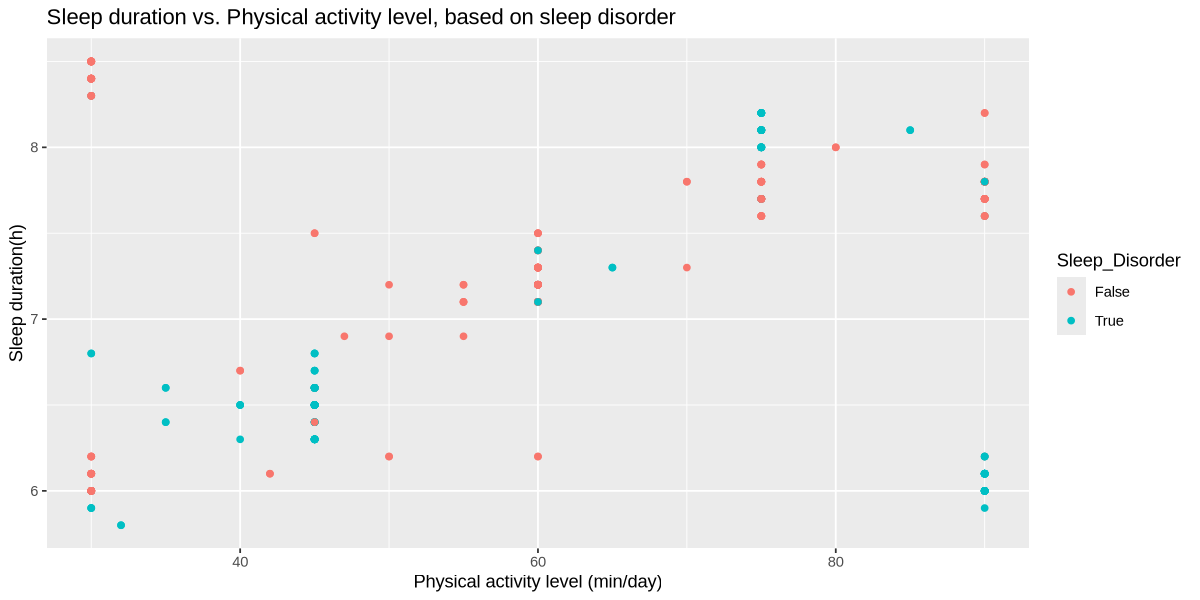

In [4]:
options(repr.plot.width=10, repr.plot.height=5)
visualization1 <- ggplot(sleep_data_reduced, aes(x= Physical_Activity_Level, y= Sleep_Duration,
                                                 color= Sleep_Disorder))+
geom_point()+
labs(x="Physical activity level (min/day)", y= "Sleep duration(h)")+
ggtitle("Sleep duration vs. Physical activity level, based on sleep disorder")
visualization1

In this plot, we see that 
 1. Physical_Activity_Level is positively correlated with Sleep_Duration, which makes sense in real life.
  2. sleep time may not be significantly affected by having sleep disorder or not.

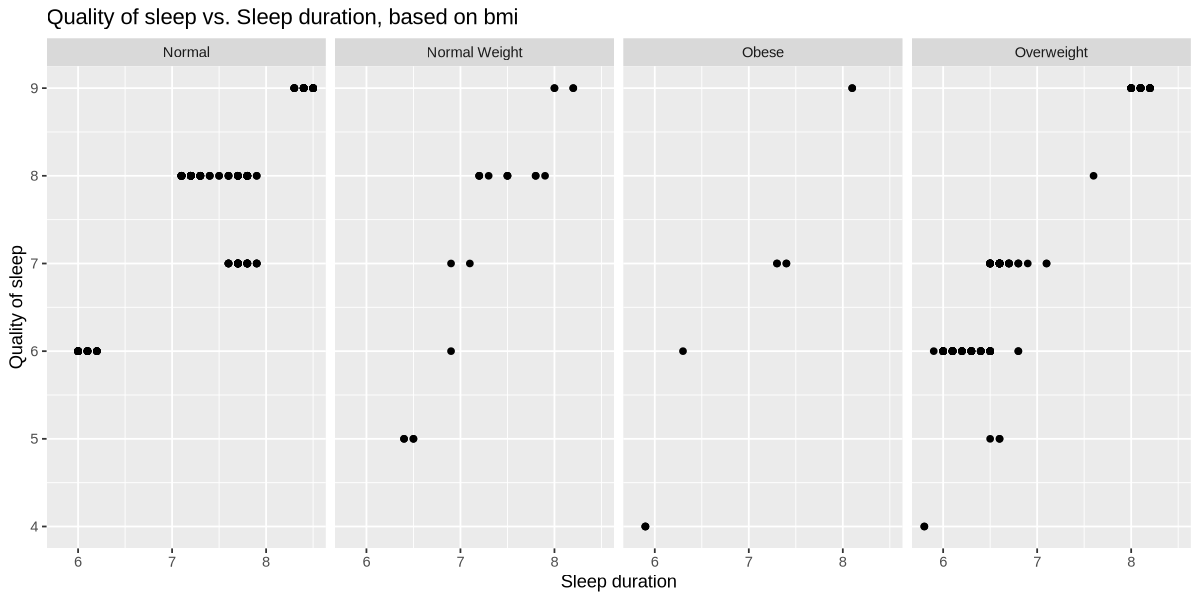

In [5]:
options(repr.plot.width=10, repr.plot.height=5)
visualization2<- ggplot(sleep_data_reduced, aes(x=Sleep_Duration, y=Quality_of_Sleep))+
geom_point()+
facet_grid(~ BMI_Category)+
ggtitle("Quality of sleep vs. Sleep duration, based on bmi")+
labs(x="Sleep duration", y="Quality of sleep")
visualization2

From this plot, we can see that 
1. people at healthier bmi generally have higher quality of sleep
2. sleep duration is positively correlated to sleep quality.

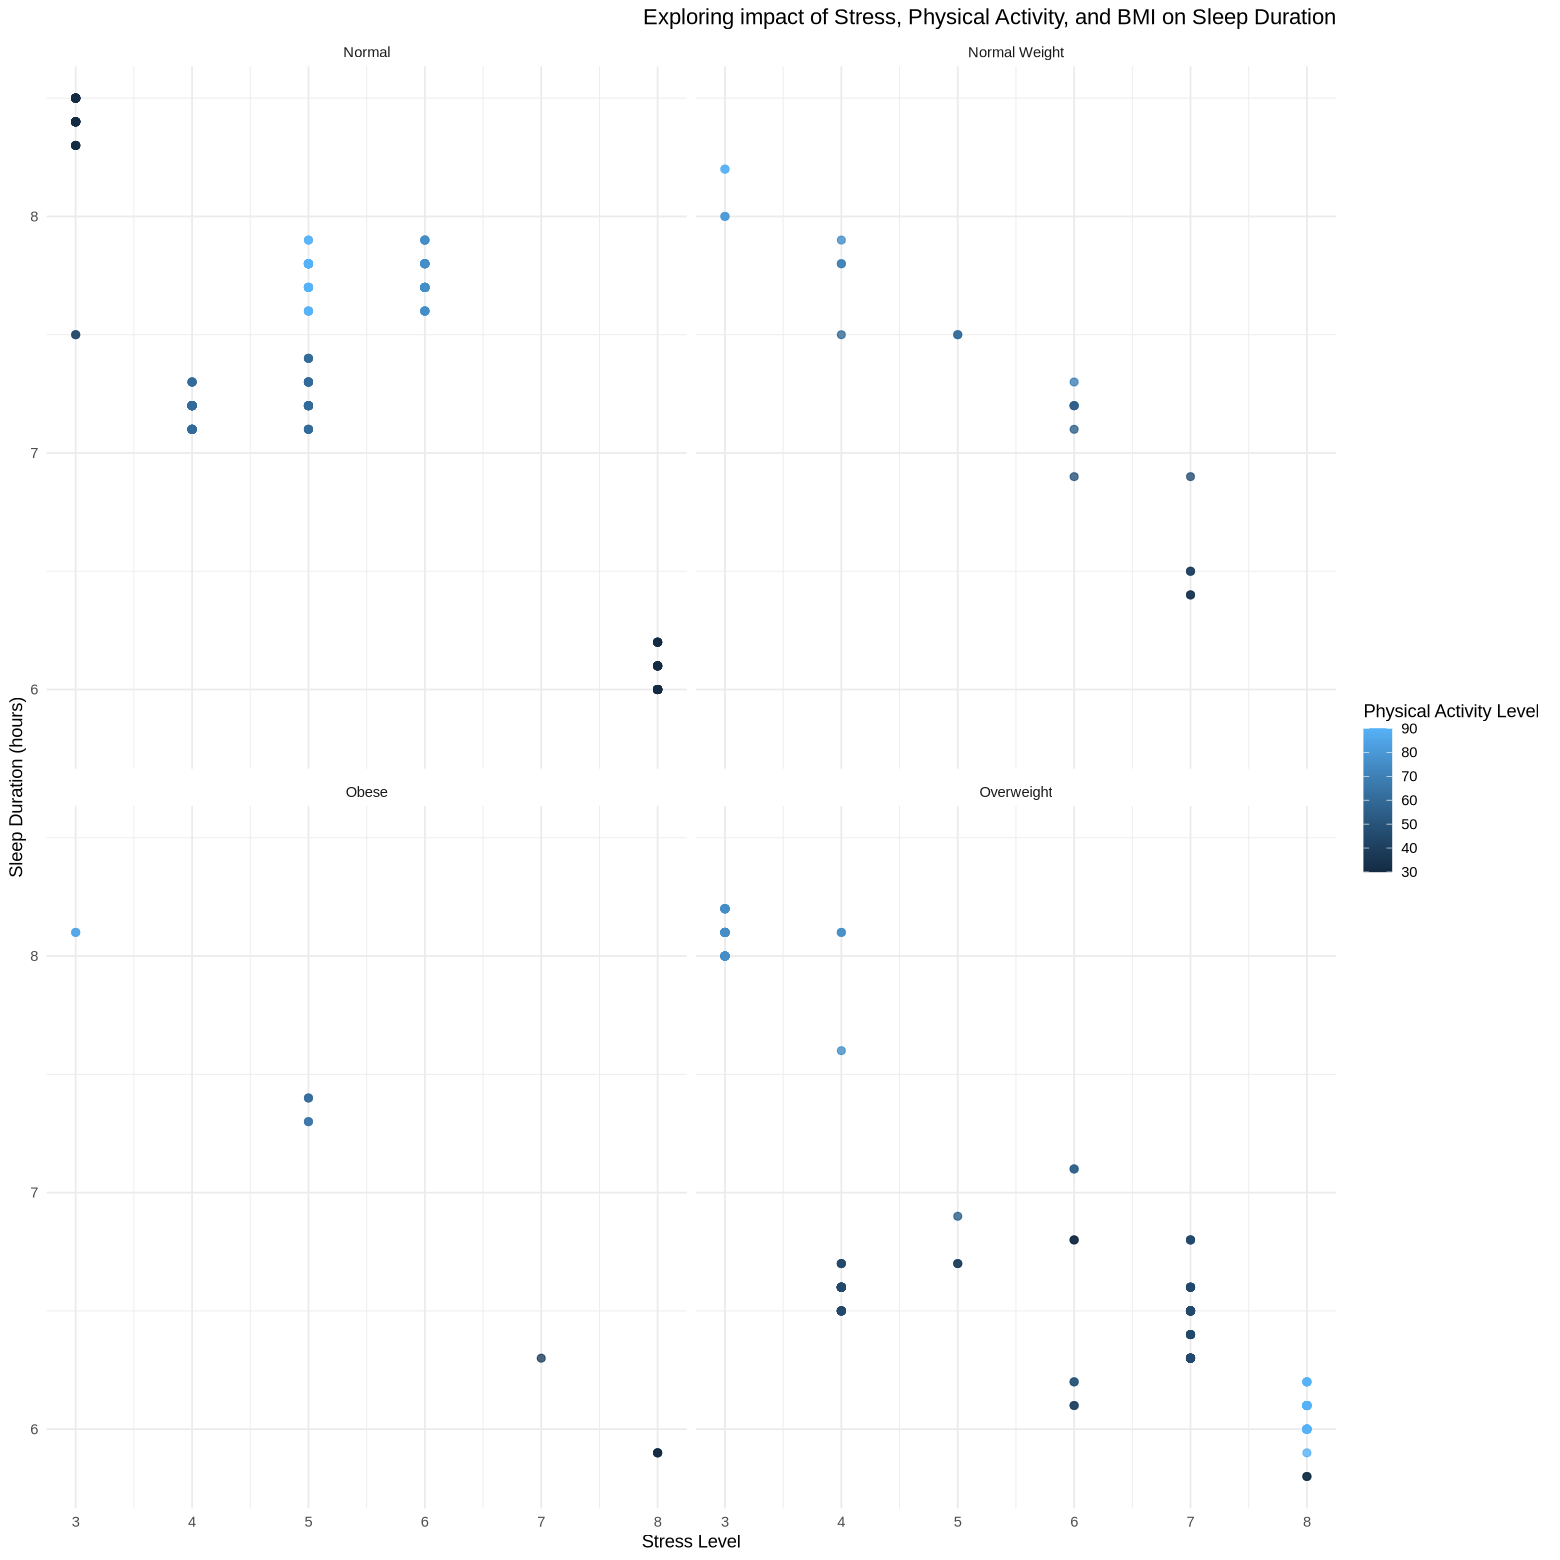

In [15]:
plot <- ggplot(sleep_data_reduced, aes(x = Stress_Level, y = Sleep_Duration, color = Physical_Activity_Level)) +
  geom_point(size = 1.9, alpha = 0.8) +                     
  facet_wrap(~ BMI_Category) +                             
  labs(title = "Exploring impact of Stress, Physical Activity, and BMI on Sleep Duration",
       x = "Stress Level",
       y = "Sleep Duration (hours)",
       color = "Physical Activity Level") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 1))

plot

From this visualization, we can see that higher physical activity often corresponds to longer sleep duration across all BMI categories. Also, increasing stress levels generally results in lower sleep duration, especially for the Normal and Overweight groups. The Obese category tends to show shorter sleep durations regardless of stress level, suggesting that BMI may further moderate how stress and physical activity interact to affect sleep. The visualization suggests that these factors may indeed interact to influence sleep, making them appropriate variables to include in the analysis. In particular, the differences across BMI categories, and the way physical activity and stress seem to correlate with sleep duration, indicate that these variables can provide meaningful insights into the research question.

#### c) Methods: Plan
I plan to use a multiple linear regression model to understand the association between a person's sleep duration and his physical health (namely bmi, physical activity level, etc.) and meantal health (such as sleep disorder, stress level, etc.)
#### Assumptions:
- Linear relationship between Sleep duration(response) and the person's physical and mental health(input)
- Errors are independent
- Conditional distribution of the error term is normal
- Variances of the error term are equal
- Furthermore, I will use variable selection methods to minimize the effect of multicollinearity.
#### Potential drawbacks and limitations:
- Even though sleep duration is a continuous variable, the relationship might not be perfectly linear
- Potential issues with our variable selection step.

In [7]:
library(car)
library(MASS)
vif(lm(Sleep_Duration ~., data=sleep_data_reduced))

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




,GVIF,Df,GVIF^(1/(2*Df))
Age,7.248862,1,2.692371
Occupation,48.395467,10,1.214060
Quality_of_Sleep,21.853408,1,4.674763
Physical_Activity_Level,1.731149,1,1.315731
Stress_Level,13.929396,1,3.732211
BMI_Category,15.237862,3,1.574541
Sleep_Disorder,3.472088,1,1.863354


We see that there are a couple of high gvif numbers. And since we have categorical variables, I choose to use AIC instead of regular stepwise variable selection.

In [8]:
#Let's first make the training and testing set
set.seed(114514)
library(rsample)
data_split <- sleep_data_reduced|> initial_split(prop=0.7, strata=Sleep_Duration)
sleep_train <- training(data_split)
sleep_test <- testing(data_split)
nrow(sleep_train)
nrow(sleep_test)
##We used a 70/30 for training and testing set

[1] 260

[1] 114

In [9]:
set.seed(114514)
modAIC<- stepAIC(lm(Sleep_Duration ~., data=sleep_train), direction = "backward", k = log(260))
summary(modAIC)
names(coef(modAIC))

Start:  AIC=-607.89
Sleep_Duration ~ Age + Occupation + Quality_of_Sleep + Physical_Activity_Level + 
    Stress_Level + BMI_Category + Sleep_Disorder

                          Df Sum of Sq    RSS     AIC
- Sleep_Disorder           1    0.0760 16.790 -612.27
- Age                      1    0.2274 16.942 -609.94
<none>                                 16.715 -607.89
- BMI_Category             3    1.3931 18.108 -603.76
- Quality_of_Sleep         1    1.2876 18.002 -594.16
- Stress_Level             1    2.0169 18.731 -583.83
- Physical_Activity_Level  1    2.9892 19.704 -570.68
- Occupation              10   12.4060 29.120 -519.16

Step:  AIC=-612.27
Sleep_Duration ~ Age + Occupation + Quality_of_Sleep + Physical_Activity_Level + 
    Stress_Level + BMI_Category

                          Df Sum of Sq    RSS     AIC
- Age                      1    0.2995 17.090 -613.24
<none>                                 16.790 -612.27
- BMI_Category             3    1.3190 18.110 -609.29
- Quality_o


Call:
lm(formula = Sleep_Duration ~ Occupation + Quality_of_Sleep + 
    Physical_Activity_Level + Stress_Level, data = sleep_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6616 -0.1587 -0.0548  0.1616  1.1758 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     4.700868   0.610355   7.702 3.27e-13 ***
OccupationDoctor                0.691842   0.070974   9.748  < 2e-16 ***
OccupationEngineer              0.578558   0.069607   8.312 6.43e-15 ***
OccupationLawyer                0.289011   0.074591   3.875 0.000137 ***
OccupationManager               0.198861   0.279523   0.711 0.477492    
OccupationNurse                 0.164997   0.070346   2.346 0.019796 *  
OccupationSales Representative  1.003075   0.233007   4.305 2.41e-05 ***
OccupationSalesperson           0.512532   0.087562   5.853 1.53e-08 ***
OccupationScientist             0.350947   0.185691   1.890 0.059941 .  
OccupationSoftware Engineer

[1] "(Intercept)"                    "OccupationDoctor"              
 [3] "OccupationEngineer"             "OccupationLawyer"              
 [5] "OccupationManager"              "OccupationNurse"               
 [7] "OccupationSales Representative" "OccupationSalesperson"         
 [9] "OccupationScientist"            "OccupationSoftware Engineer"   
[11] "OccupationTeacher"              "Quality_of_Sleep"              
[13] "Physical_Activity_Level"        "Stress_Level"

In [10]:
levels(sleep_train$Occupation)
##although the aic did not exactly go as I planned, as in it only gives Occupation as one covariate, but since it gives 10 out of 11 levels in 
##Occupation, I will take the bold yet highly likely guess that the whole Occupation is selected
vif(lm(Sleep_Duration~ Occupation + Quality_of_Sleep + Physical_Activity_Level + Stress_Level, data=sleep_test))
## We see that vif is looking a LOT better!

[1] "Accountant"           "Doctor"               "Engineer"            
 [4] "Lawyer"               "Manager"              "Nurse"               
 [7] "Sales Representative" "Salesperson"          "Scientist"           
[10] "Software Engineer"    "Teacher"

,GVIF,Df,GVIF^(1/(2*Df))
Occupation,4.535298,8,1.099102
Quality_of_Sleep,10.422046,1,3.228319
Physical_Activity_Level,1.596646,1,1.263584
Stress_Level,9.327182,1,3.054044


In [11]:
tidy(lm(Sleep_Duration~ Occupation + Quality_of_Sleep + Physical_Activity_Level + Stress_Level, data=sleep_test))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.287309510,0.776628340,8.0956478,1.266878e-12
OccupationDoctor,0.758514380,0.119098763,6.3687847,5.547333e-09
OccupationEngineer,0.647082668,0.112509885,5.7513406,9.307889e-08
OccupationLawyer,0.384369968,0.121941123,3.1520947,2.128736e-03
OccupationNurse,0.249098643,0.116127828,2.1450383,3.432375e-02
OccupationSalesperson,0.351817121,0.156218800,2.2520793,2.646026e-02
OccupationScientist,0.563602644,0.346222134,1.6278643,1.066388e-01
OccupationSoftware Engineer,0.342137026,0.206543539,1.6564886,1.006961e-01
OccupationTeacher,-0.126025530,0.135748149,-0.9283775,3.554035e-01


Using the testing set, we see that the p values look very nice, thanks to the earlier variable selection.

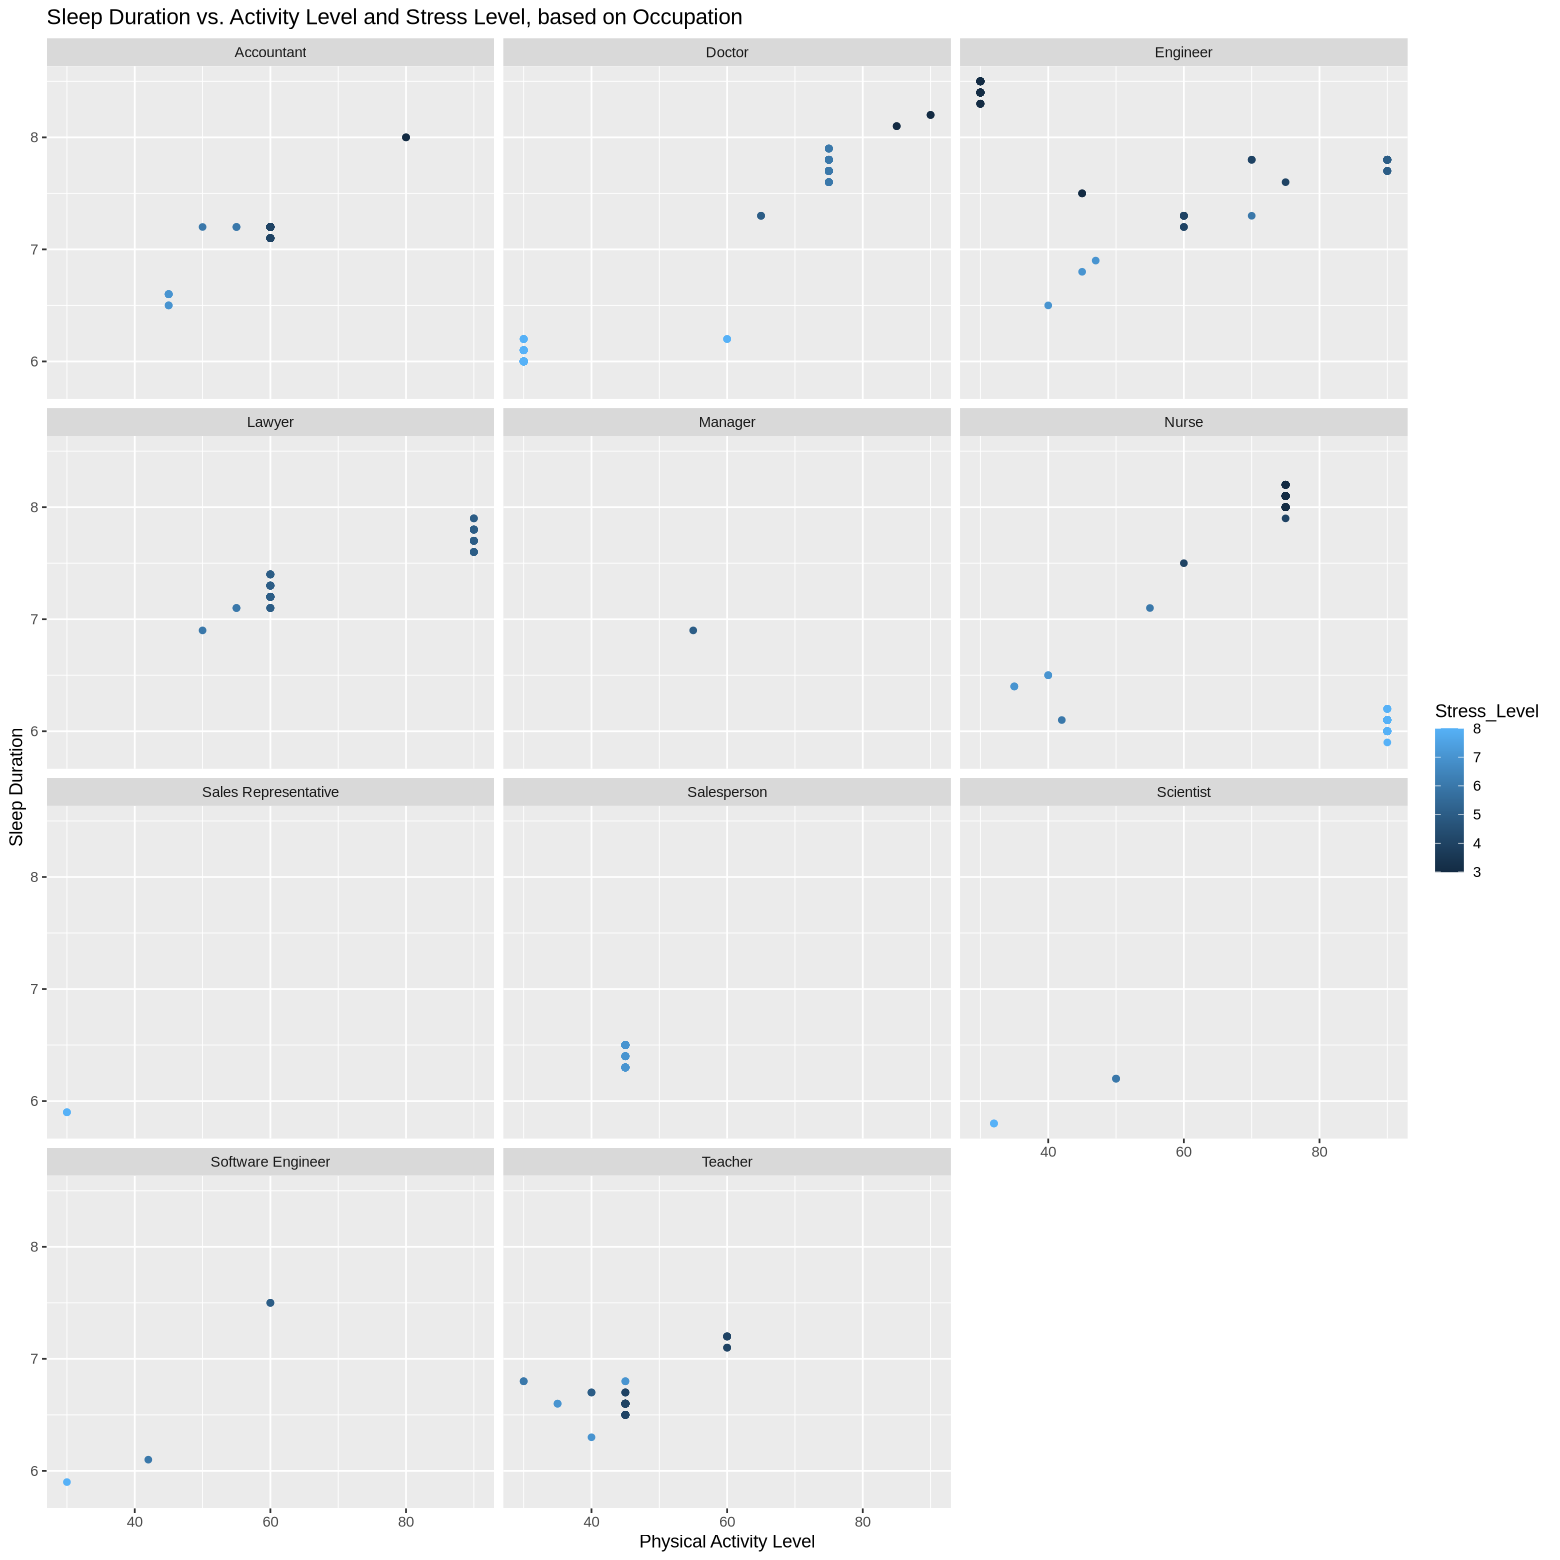

In [12]:
options(repr.plot.width=13, repr.plot.height=13)
visualization3<- ggplot(sleep_data_reduced, aes(x=Physical_Activity_Level, y=Sleep_Duration, color = Stress_Level))+
geom_point()+
facet_wrap(~ Occupation, nrow = 4, ncol=3)+
ggtitle("Sleep Duration vs. Activity Level and Stress Level, based on Occupation")+
labs(x="Physical Activity Level", y="Sleep Duration")
visualization3


We see the general trend that the lower stress level, the longer sleep duration, and the higher physical activity, the longer sleep duration, and we see that occupation definitely plays a role in affecting a person's sleep duration as well

Hello how are you doing pt 2
add r^s, rss, etc between code cell 18 and 19 to show how valid model is
make stepAic more valid by showing occupation as one thing.
add discussion
and citation


## 3. Discussion

## 4. References:

Grandner, M. A. (2017). Sleep, health, and society. Sleep Medicine Clinics, 12(1), 1–22. https://doi.org/10.1016/j.jsmc.2016.10.012

Khan, M. S., & Aouad, R. (2017). The effects of insomnia and sleep loss on cardiovascular disease. Sleep Medicine Clinics, 12(2), 167–177. https://doi.org/10.1016/j.jsmc.2017.01.005

Medic, G., Wille, M., & Hemels, M. E. (2017). Short- and long-term health consequences of sleep disruption. Nature and Science of Sleep, 9, 151–161. https://doi.org/10.2147/NSS.S134864